In [1]:
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import newaxis
import time
import holidays
import pickle
import warnings
warnings.filterwarnings("ignore") # may not always be the best thing to do...
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

## Link colab to your google drive
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Nilm metric
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

# Custom metric for fit
def custom_metric(y_true, y_pred):
        score = mt.sqrt(sum((y_pred.get_label() - y_true) ** 2) / len(y_true)) * 4.95
        score /= 74.86
        return "nilm", score

# Create final y dataframe
def create_y_predictions(x_out_old, x_out, best_model):
  Y_out_temp = best_model.predict(x_out)
  df = pd.DataFrame(Y_out_temp)
  Y_out = pd.DataFrame(x_out_old["time_step"])
  Y_out["washing_machine"] = df.iloc[:,0]
  Y_out["fridge_freezer"] = df.iloc[:,1]
  Y_out["TV"] = df.iloc[:,2]
  Y_out["kettle"] = df.iloc[:,3]
  Y_out.index = Y_out.time_step #ligne de nao
  Y_out.to_csv('y_out.csv', header=True,index=False)
  print(Y_out)
  files.download("y_out.csv")
  return Y_out

#Modif of output
def modif_output(y_pred2_df):
  y_pred2_df['kettle'] = y_pred2_df['kettle'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['TV'] = y_pred2_df['TV'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['fridge_freezer'] = y_pred2_df['fridge_freezer'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['washing_machine'] = y_pred2_df['washing_machine'].apply(lambda x : 0 if x<=1 else x)
  return y_pred2_df

In [3]:
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data.csv")
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,time_step,washing_machine,fridge_freezer,TV,kettle,month,day,hour,day_of_week,minute,n_days,is_holiday,is_weekend,sin_hour,cos_hour,sin_day,cos_day,sin_dow,cos_dow,peak_hours,is_breakfast,is_teatime,is_evening,avg_hourly_consumption,avg_day_of_weekly_consumption,avg_hourly_washing_machine,avg_day_of_weekly_washing_machine,avg_hourly_fridge_freezer,avg_day_of_weekly_fridge_freezer,avg_hourly_TV,avg_day_of_weekly_TV,avg_hourly_kettle,...,log_conso + 1,log_conso - 2,log_conso + 2,log_conso - 3,log_conso + 3,log_conso - 5,log_conso + 5,log_conso - 10,log_conso + 10,log_conso - 30,log_conso + 30,log_conso - 60,log_conso + 60,log_conso - 120,log_conso + 120,conso_normalised,conso / mvg_std_10,conso / mvg_std_30,conso / mvg_std_60,conso_trend,conso_anomaly,conso_low,conso_cumsum_mvg_avg_30,moving_conso_mean_3,conso - mvg_avg_3,moving_conso_mean_5,conso - mvg_avg_5,conso_cumsum_mvg_avg_3,conso_cumsum_mvg_avg_5,conso_cumsum_mvg_avg_10,conso_cumsum_mvg_avg_15,conso_cumsum_mvg_avg_20,conso_cumsum_mvg_avg_60,cumsum_diff_3,cumsum_diff_5,cumsum_diff_10,cumsum_diff_15,cumsum_diff_20,cumsum_diff_30,cumsum_diff_60
0,550.4000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0,3,17,0,6,1,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307370,6.310645,6.308645,6.310645,6.308766,6.310645,6.309251,6.310645,6.305180,6.310645,6.369730,6.310645,6.424058,6.310645,6.288849,473.890573,802.337957,69.811813,22.620646,520.917237,0,0,4.382633,549.433333,0.966667,549.31152,1.08848,0.966667,1.088480e+00,1.12024,3.326827,5.96637,-14.83883,0.000000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000
1,548.6000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0,3,17,0,6,2,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308645,6.310645,6.308766,6.310645,6.307900,6.310645,6.307135,6.310645,6.303534,6.310645,6.356108,6.310645,6.293543,6.310645,6.289509,472.090573,802.337957,69.811813,22.620646,520.827729,0,0,6.965267,549.433333,-0.833333,549.31152,-0.71152,0.133333,3.769600e-01,0.44048,4.853653,10.13274,-31.47766,-0.700000,-0.70000,-0.7000,-0.7000,-0.7000,-0.7000,-0.7000
2,549.3000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0,3,17,0,6,3,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308766,6.310645,6.307900,6.310645,6.309251,6.310645,6.310311,6.310645,6.303900,6.310645,6.352629,6.310645,6.293789,6.310645,6.276435,472.790573,802.337957,69.811813,22.620646,520.738222,0,0,10.247900,549.433333,-0.133333,549.31152,-0.01152,0.000000,3.654400e-01,0.46072,7.080480,14.99911,-47.41649,-0.411133,-0.06670,-0.0667,-0.0667,-0.0667,-0.0667,-0.0667
3,549.3667,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0,3,17,0,6,4,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307900,6.307370,6.309251,6.310645,6.307135,6.310645,6.308908,6.310645,6.289344,6.310645,6.351584,6.310645,6.292495,6.310645,6.422882,472.857273,802.337957,69.811813,22.620646,520.648714,0,0,13.597233,549.088900,0.277800,549.31152,0.05518,0.277800,4.206200e-01,0.54766,9.374007,19.93218,-63.28862,0.572767,0.47580,0.4758,0.4758,0.4758,0.4758,0.4758
4,548.8909,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0,3,17,0,6,5,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,

In [0]:
def add_cumsum_moving(data,window):
  data["conso_cumsum_mvg_avg_"+str(window)] = data["conso - mvg_avg_"+str(window)].cumsum()
  return data

def add_cumsum_diff(data,window):
  data["cumsum_diff_"+str(window)] = data["conso_cumsum_mvg_avg_"+str(window)].diff(periods=1).fillna(method="bfill") + data["conso_cumsum_mvg_avg_"+str(window)].diff(periods=-1).fillna(method="ffill")
  return data

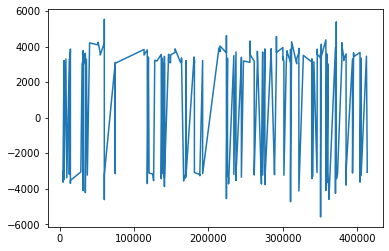

In [14]:
data["conso_cumsum_mvg_avg_3"] = (data.consumption.rolling(3).mean().shift(-3) - data.consumption.rolling(3).mean().shift(1).fillna(method="ffill")).fillna(method="bfill").fillna(method="ffill")
data.consumption.rolling(4).mean().shift(-3)
data.consumption.rolling(4).mean().shift(1)
data["conso_cumsum_mvg_avg_3"][abs(data["conso_cumsum_mvg_avg_3"])>3000].plot()

# Model 0 : 36.3 platform, 38.4 local

## 1. First fit an XGBoost on all four appliances. 

In [0]:
removed_features = ["expanding_conso_mean_10","expanding_conso_max_10", "expanding_conso_min_10",
                    "expanding_conso_median_10", "expanding_conso_std_10", "expanding_conso_mean_30", 
                    "expanding_conso_max_30", "expanding_conso_min_30", "expanding_conso_median_30",
                    "expanding_conso_std_30", "expanding_conso_mean_60", "expanding_conso_max_60",
                    "expanding_conso_min_60", "expanding_conso_median_60", "expanding_conso_std_60",]

In [0]:
temp_features = ["rolling_std_future_5", "rolling_std_future_10", "rolling_std_past_5", "rolling_std_past_10",
                 "rolling_std_future_3", "rolling_std_past_3","rolling_max_5", "rolling_max_3",]

In [0]:
selected_features =  ['consumption', 
                      'conso - 1', 'conso - 2', 'conso - 3', 'conso - 5', 'conso - 10', 'conso - 30', 'conso - 60',
                      'conso + 1', 'conso + 2', 'conso + 3', 'conso + 5', 'conso + 10', 'conso + 30', 'conso + 60',
                      'moving_conso_mean_10','moving_conso_mean_30', 'moving_conso_mean_60', 
                      'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
                      'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
                      'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
                      'moving_conso_mean_15', 'moving_conso_min_15', 'moving_conso_max_15',
                      'moving_conso_mean_20', 'moving_conso_min_20', 'moving_conso_max_20',
                      "conso - mvg_avg_10","conso - mvg_avg_30","conso - mvg_avg_60",
                      "conso - mvg_avg_15", "conso - mvg_avg_20",
                      "conso - avg_hourly_kettle",
                      'cos_hour', 'sin_hour', 'cos_day', 'sin_day', 'cos_dow', 'sin_dow',
                      'n_days', "hour", "month", "day_of_week",
                      'temperature','pressure',
                      'peak_hours', 
                      'avg_hourly_consumption', 'avg_hourly_washing_machine','avg_hourly_fridge_freezer','avg_hourly_TV','avg_hourly_kettle',
                      'avg_day_of_weekly_consumption','avg_day_of_weekly_washing_machine','avg_day_of_weekly_fridge_freezer',
                      'avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                      "conso_anomaly","is_teatime", "is_winter", "conso_low",
                      "conso_cumsum_mvg_avg_30"
                      ]

In [0]:
X = data.loc[:,selected_features]
y = data.loc[:, "washing_machine":"kettle"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [30]:
xgb_reg = XGBRegressor(n_estimators=300,
                       learning_rate = 0.1,
                       max_depth=3)
multi_reg = MultiOutputRegressor(xgb_reg,n_jobs=-1)
multi_reg.fit(X_train,y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=300,
                                            n_jobs=1, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbos

In [0]:
#Prepare y_pred to be able to use their custom metrics
y_pred = multi_reg.predict(X_test)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_df.index = y_test.index

#Prepare y_pred_train to be able to use their custom metrics
y_pred_train = multi_reg.predict(X_train)
y_pred_train_df = pd.DataFrame(y_pred_train)
y_pred_train_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_train_df.index = y_train.index

In [32]:
metric_nilm(y_test, y_pred_df), metric_nilm(y_train, y_pred_train_df) 

(38.67838914484194, 30.640630028580002)

In [33]:
# Fridge freezer
pred = y_pred[:,1]
test = y_test.iloc[:,1]
mt.sqrt(sum((pred - test)**2)/len(test))*49.79/74.86

27.14374311292889

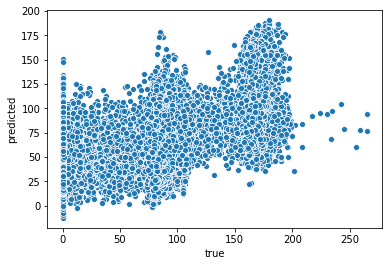

In [34]:
df = pd.DataFrame(y_pred_df["fridge_freezer"])
df["true"] = y_test["fridge_freezer"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [35]:
# Fridge freezer on train
pred = y_pred_train[:,1]
test = y_train.iloc[:,1]
mt.sqrt(sum((pred - test)**2)/len(test))*49.79/74.86

24.2477087134754

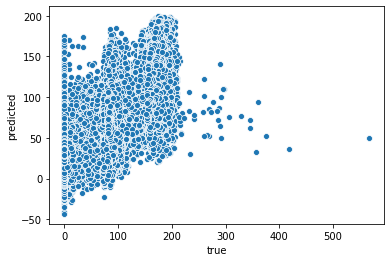

In [36]:
df1 = pd.DataFrame(y_pred_train_df["fridge_freezer"])
df1["true"] = y_train["fridge_freezer"]
df1.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df1)

In [37]:
# TV
pred = y_pred[:,2]
test = y_test.iloc[:,2]
mt.sqrt(sum((pred - test)**2)/len(test))*14.57/74.86

2.971176331281967

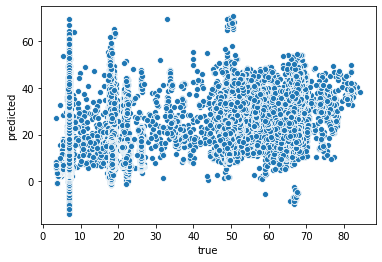

In [38]:
df = pd.DataFrame(y_pred_df["TV"])
df["true"] = y_test["TV"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [39]:
# TV train
pred = y_pred_train[:,2]
test = y_train.iloc[:,2]
mt.sqrt(sum((pred - test)**2)/len(test))*14.57/74.86

2.298569856043738

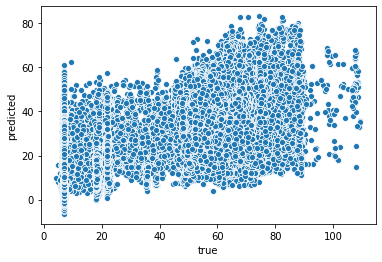

In [40]:
df1 = pd.DataFrame(y_pred_train_df["TV"])
df1["true"] = y_train["TV"]
df1.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df1)

In [41]:
# Kettle
pred = y_pred[:,3]
test = y_test.iloc[:,3]
mt.sqrt(sum((pred - test)**2)/len(test))*4.95/74.86

5.337415645599091

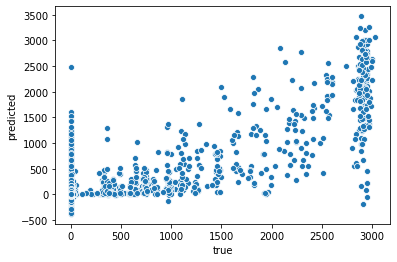

In [42]:
df = pd.DataFrame(y_pred_df["kettle"])
df["true"] = y_test["kettle"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [43]:
# Kettle train
pred = y_pred_train[:,3]
test = y_train.iloc[:,3]
mt.sqrt(sum((pred - test)**2)/len(test))*4.95/74.86

2.0738977348485124

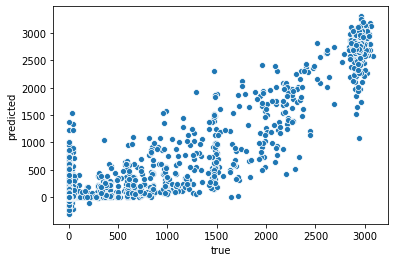

In [44]:
df1 = pd.DataFrame(y_pred_train_df["kettle"])
df1["true"] = y_train["kettle"]
df1.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df1)

In [45]:
# Washing machine
pred = y_pred[:,0]
test = y_test.iloc[:,0]
mt.sqrt(sum((pred - test)**2)/len(test))*5.55/74.86

3.2260540550319865

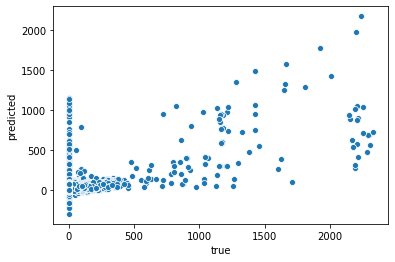

In [46]:
df = pd.DataFrame(y_pred_df["washing_machine"])
df["true"] = y_test["washing_machine"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [47]:
# Washing machine train
pred = y_pred_train[:,0]
test = y_train.iloc[:,0]
mt.sqrt(sum((pred - test)**2)/len(test))*5.55/74.86

2.020453724212354

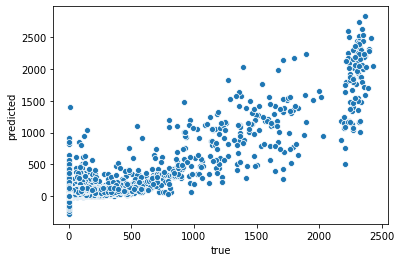

In [48]:
df1 = pd.DataFrame(y_pred_train_df["washing_machine"])
df1["true"] = y_train["washing_machine"]
df1.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df1)

## 2. Then predict kettle on its own

- Started from the features for fridge freezer at 25
- Introduced early stopping after 3 rounds if the score doesn't improve: got us down from 10.5 to 3.47 locally
- Replacing conso normalised ff by conso normalised TV, and conso - avg hourly ff by TV+ adding rolling std 30 and 60 past and future, IDK what it did but lowering the lr was good idea and got me to 3.39 apparently

In [1]:
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data.csv")
data.head()

NameError: ignored

In [0]:
removed_features = ["expanding_conso_mean_10","expanding_conso_max_10", "expanding_conso_min_10", 
                    "expanding_conso_median_10", "expanding_conso_std_10", "expanding_conso_mean_30", 
                    "expanding_conso_max_30", "expanding_conso_min_30", "expanding_conso_median_30",
                    "expanding_conso_std_30", "expanding_conso_mean_60", "expanding_conso_max_60",
                    "expanding_conso_min_60", "expanding_conso_median_60", "expanding_conso_std_60",

                    'avg_day_of_weekly_washing_machine','avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                    'avg_day_of_weekly_consumption','avg_day_of_weekly_fridge_freezer',

                    "minutely_std_fridge_freezer", # all removed from fridge freezer

                    "rolling_std_future_5", "rolling_std_future_10", "rolling_std_past_5", "rolling_std_past_10",
                    "rolling_std_future_3",
                       
                    ]

In [0]:
features_kettle =  ['consumption', 
                      'conso - 1', 'conso - 2', 'conso - 3', 'conso - 5', 'conso - 10', 'conso - 30', 'conso - 60',
                      'conso + 1', 'conso + 2', 'conso + 3', 'conso + 5', 'conso + 10', 'conso + 30', 'conso + 60',
                      'moving_conso_mean_10','moving_conso_mean_30', 'moving_conso_mean_60', 
                      'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
                      'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
                      'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
                      'moving_conso_mean_15', 'moving_conso_min_15', 'moving_conso_max_15',
                      'moving_conso_mean_20', 'moving_conso_min_20', 'moving_conso_max_20',
                      "conso - mvg_avg_10","conso - mvg_avg_30","conso - mvg_avg_60",
                      "conso - mvg_avg_15", "conso - mvg_avg_20",
                      "conso - avg_hourly_kettle",
                      'cos_day', 'sin_day', 'cos_hour', 'sin_hour','cos_dow', 'sin_dow',
                      'n_days', "hour", "month", "day_of_week",
                      'temperature','pressure',"wind",
                      'peak_hours', 
                      'avg_hourly_consumption', 'avg_hourly_washing_machine','avg_hourly_fridge_freezer','avg_hourly_TV','avg_hourly_kettle',
                      'avg_day_of_weekly_consumption',
                      'avg_day_of_weekly_washing_machine','avg_day_of_weekly_fridge_freezer',
                      'avg_day_of_weekly_TV',
                      'avg_day_of_weekly_kettle',
                      #"conso_anomaly",
                      "is_breakfast", "is_teatime",
                      "rolling_std_past_3",
                      "rolling_std_future_30",
                      "rolling_std_future_3",
                      "conso_normalised",
                      ]

In [0]:
features_kettle =   ['consumption', 
                      'conso - 1','conso - 2','conso - 3','conso - 5','conso - 10', 'conso - 30', 'conso - 60', 
                      'conso + 1', 'conso + 2', 'conso + 3', 'conso + 5', 'conso + 10', 'conso + 30', 'conso + 60',
                     'cos_hour', 'sin_hour', 'sin_day','cos_day', 'sin_dow', 'cos_dow',
                     'n_days',
                     'pressure', 'temperature',
                     'peak_hours', 'avg_hourly_consumption',  
                     'moving_conso_mean_10','moving_conso_mean_30', 'moving_conso_mean_60', 
                     'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
                     'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
                     'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
                     'moving_conso_mean_15','moving_conso_mean_20',
                     'moving_conso_min_15', 'moving_conso_min_20',
                     'moving_conso_max_15', 'moving_conso_max_20',
                     "conso - mvg_avg_10","conso - mvg_avg_15", "conso - mvg_avg_20",
                     "conso - mvg_avg_30","conso - mvg_avg_60",
                     'avg_hourly_washing_machine','avg_hourly_fridge_freezer','avg_hourly_TV','avg_hourly_kettle',
                     "conso - avg_hourly_kettle",
                     'avg_day_of_weekly_washing_machine','avg_day_of_weekly_consumption','avg_day_of_weekly_fridge_freezer','avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                     "hour", "month", "day_of_week",
                     "minutely_std_fridge_freezer",
                     "conso_normalised","conso / mvg_std_10", "conso / mvg_std_30","conso / mvg_std_60",
                     ]

In [0]:
X2 = data.loc[:, features_kettle]
y2 = data.loc[:, "washing_machine":"kettle"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, 
                                                        y2, 
                                                        test_size=0.20, 
                                                        shuffle=False)

In [26]:
xgb_reg = XGBRegressor(n_estimators=300,
                       max_depth = 3,
                       learning_rate=0.1)
xgb_reg.fit(X_train2,
            y_train2.iloc[:,3],
            eval_set=[(X_test2, y_test2.iloc[:,3])],
            eval_metric=custom_metric,)
            #early_stopping_rounds=10)

[20:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:143.784	validation_0-nilm:9.50762
[1]	validation_0-rmse:137.844	validation_0-nilm:9.1148
[2]	validation_0-rmse:132.157	validation_0-nilm:8.73877
[3]	validation_0-rmse:127.433	validation_0-nilm:8.42637
[4]	validation_0-rmse:123.649	validation_0-nilm:8.17619
[5]	validation_0-rmse:120.142	validation_0-nilm:7.94428
[6]	validation_0-rmse:116.696	validation_0-nilm:7.71637
[7]	validation_0-rmse:114.242	validation_0-nilm:7.5541
[8]	validation_0-rmse:111.778	validation_0-nilm:7.39119
[9]	validation_0-rmse:109.269	validation_0-nilm:7.22534
[10]	validation_0-rmse:107.693	validation_0-nilm:7.12112
[11]	validation_0-rmse:105.653	validation_0-nilm:6.98622
[12]	validation_0-rmse:103.52	validation_0-nilm:6.84515
[13]	validation_0-rmse:101.745	validation_0-nilm:6.72782
[14]	validation_0-rmse:100.179	validation_0-nilm:6.62425
[15]	validation_0-rmse:99.1766	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

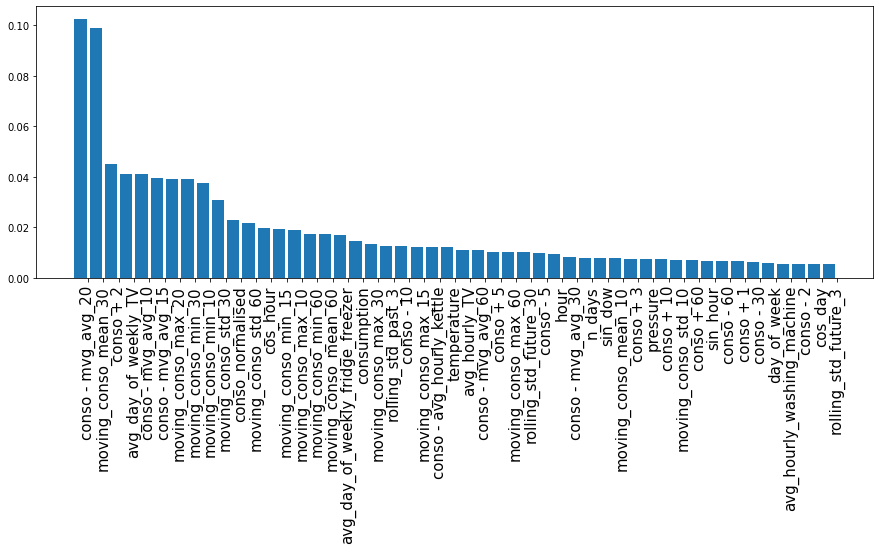

In [8]:
# Looking at the importance of each column and the prediction 
X_columns = X_train2.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(xgb_reg.feature_importances_)[::-1][:50]
importances = xgb_reg.feature_importances_[ordering]
feature_names = X_columns[ordering]
axis = np.arange(len(feature_names))
plt.bar(axis, importances)
plt.xticks(axis + 0.5, feature_names, rotation=90, fontsize=15);

In [112]:
# Metric nilm kettle
pred = xgb_reg.predict(X_test2)
test = y_test2.iloc[:,3]
mt.sqrt(sum((pred - test)**2)/len(test))*4.95/74.86

5.371418461087772

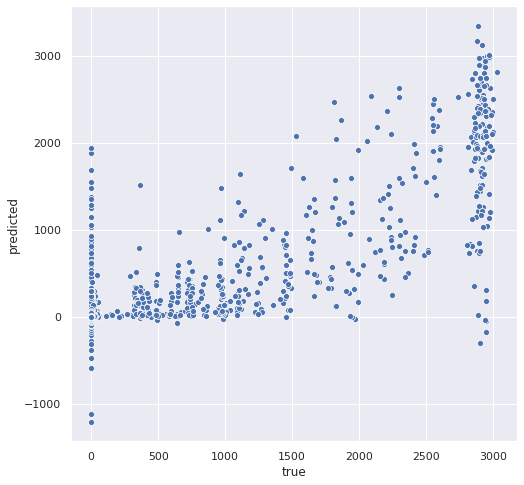

In [103]:
df = pd.DataFrame(pred)
df["true"] = np.array(test)
df.columns = ["predicted","true"]
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x= "true",y = "predicted", data=df)

In [0]:
#xgb_reg = XGBRegressor(n_estimators=100,
#                       max_depth = 10,
#                       learning_rate=0.1)
#xgb_reg.fit(X2,
#            y2.iloc[:,2],
#            early_stopping_rounds=3)

In [0]:
x_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/x_out.csv")
Y_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_wm_3_full_data.csv")

In [0]:
#Y_out.to_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_TV_4.csv", index=False)

In [0]:
features_kettle = ['consumption', 
                   'conso - 1', 'conso - 2', 'conso - 3', 'conso - 5', 'conso - 10', 'conso - 30', 'conso - 60',
                   'conso + 1', 'conso + 2', 'conso + 3', 'conso + 5', 'conso + 10', 'conso + 30', 'conso + 60',
                   'moving_conso_mean_10','moving_conso_mean_30', 'moving_conso_mean_60', 
                   'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
                   'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
                   'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
                   'moving_conso_mean_15', 'moving_conso_min_15', 'moving_conso_max_15',
                   'moving_conso_mean_20', 'moving_conso_min_20', 'moving_conso_max_20',
                   "conso - mvg_avg_10","conso - mvg_avg_30","conso - mvg_avg_60",
                   "conso - mvg_avg_15", "conso - mvg_avg_20",
                   "conso - avg_hourly_kettle",
                   'cos_hour', 'sin_hour', 'cos_day', 'sin_day', 'cos_dow', 'sin_dow',
                   'n_days', "hour", "month", "day_of_week",
                   'temperature','pressure',
                   'peak_hours', 
                   'avg_hourly_consumption', 'avg_hourly_washing_machine','avg_hourly_fridge_freezer','avg_hourly_TV','avg_hourly_kettle',
                   'avg_day_of_weekly_consumption','avg_day_of_weekly_washing_machine','avg_day_of_weekly_fridge_freezer',
                   'avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                   "conso_anomaly",
                   "is_teatime", "is_winter",
                   "conso_low"
                      ]